In [90]:
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt

#### Functions

1. User-preferences Weights Calculations - Fuzzy Logic
2. Service QoS Weights Calculations - AHP
3. Normalisation 
4. Final Weights Calculation RAT layer
5. MEW
6. SAW

#### 1. Fuzzy Membership Funtion

In [91]:
def fuzzy_membership(criteria_value, preference, min_value, max_value):
    """
    Calculate the fuzzy membership value for a given criteria.
    
    :param criteria_value: The value of the criteria to evaluate
    :param preference: 'low', 'medium', or 'high'
    :param min_value: The minimum value for the criteria range
    :param max_value: The maximum value for the criteria range
    :return: Membership value between 0 and 1
    """
    
    def low_mf(x, b, c):
        return np.where(x <= b, 1, max(0, (c - x) / (c - b)))
    
    def medium_mf(x, a, b, c):
        return max(0, min((x - a) / (b - a), (c - x) / (c - b)))
    
    def high_mf(x, a, b):
        return np.where(x >= b, 1, max(0, (x - a) / (b - a)))
    
    # Calculate the range
    value_range = max_value - min_value

    preference = preference.lower()
    # Set ratios for a, b, c based on the range
    if preference == 'low':
        b = min_value + 0.25 * value_range
        c = min_value + 0.5 * value_range
        return low_mf(criteria_value, b, c)
    
    elif preference == 'medium':
        a = min_value + 0.25 * value_range
        b = min_value + 0.5 * value_range
        c = min_value + 0.75 * value_range
        return medium_mf(criteria_value, a, b, c)
    
    elif preference == 'high':
        a = min_value + 0.5 * value_range
        b = min_value + 0.75 * value_range
        return high_mf(criteria_value, a, b)
    
    else:
        raise ValueError("Preference must be 'low', 'medium', or 'high'")

In [92]:
def qos_to_no(preference: str) -> float:
    """
    Convert a QoS preference string to its corresponding numerical value.
    
    Args:
    preference (str): A string representing the QoS preference. 
                      Must be either "Low", "Medium", or "High" (case-insensitive).
    
    Returns:
    float: The numerical value corresponding to the preference.
    
    Raises:
    ValueError: If an invalid preference is provided.
    """
    preference_map = {
        "low": 0.01,
        "medium": 0.50,
        "high": 0.99
    }
    
    normalized_preference = preference.lower()
    
    if normalized_preference not in preference_map:
        raise ValueError("Invalid preference. Must be 'Low', 'Medium', or 'High'.")
    
    return preference_map[normalized_preference]

#### 2. AHP Function

In [93]:
def ahp_weights(matrix):
    """
    Calculate weights and Consistency Index for AHP pairwise comparison matrix.
    
    Args:
    matrix (np.array): Square pairwise comparison matrix
    
    Returns:
    tuple: (weights, consistency_index)
    """
    # Check if the matrix is square
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("Matrix must be square")
    
    n = matrix.shape[0]
    
    # Calculate the principal eigenvalue and eigenvector
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    max_index = np.argmax(eigenvalues)
    max_eigenvalue = eigenvalues[max_index].real
    eigenvector = eigenvectors[:, max_index].real
    
    # Normalize the eigenvector to get the weights
    weights = eigenvector / np.sum(eigenvector)
    
    # Calculate the Consistency Index
    ci = (max_eigenvalue - n) / (n - 1)
    
    # Calculate the Random Index
    ri_values = {1: 0, 2: 0, 3: 0.58, 4: 0.9, 5: 1.12, 6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45, 10: 1.49}
    ri = ri_values.get(n, 1.49)  # Use 1.49 for n > 10
    
    # Calculate the Consistency Ratio
    cr = ci / ri if ri != 0 else 0
    if cr >= 0.1:
        raise ValueError("Not Consistent!")
    
    return weights

#### 3. Normalisation

In [94]:
def square_root_normalize(matrix, criteria_types):
    """
    Normalize the matrix using square root normalization,
    accounting for upward and downward criteria.
    
    :param matrix: numpy array of shape (n_rats, n_criteria)
    :param criteria_types: list of strings, either 'up' or 'down' for each criterion
    :return: normalized matrix
    """
    normalized = np.zeros_like(matrix, dtype=float)
    
    for j in range(matrix.shape[1]):
        if criteria_types[j] == 'up':
            normalized[:, j] = matrix[:, j] / np.sqrt(np.sum(matrix[:, j]**2))
        elif criteria_types[j] == 'down':
            normalized[:, j] = 1 - (matrix[:, j] / np.sqrt(np.sum(matrix[:, j]**2)))
        else:
            raise ValueError(f"Invalid criterion type: {criteria_types[j]}. Must be 'up' or 'down'.")
    
    return normalized

def minmax_normalize(matrix, criteria_types):
    """
    Normalize RAT criteria matrix using Max-Min function.
    
    :param matrix: 2D numpy array where each row represents a RAT and each column a criterion
    :param criteria_types: List of strings ('up' or 'down') indicating whether each criterion is upward or downward
    :return: Normalized matrix
    """
    normalized = np.zeros_like(matrix, dtype=float)
    
    for j in range(matrix.shape[1]):
        column = matrix[:, j]
        col_min, col_max = np.min(column), np.max(column)
        if col_min == col_max:
            col_min -= 1
        
        if criteria_types[j] == 'up':
            normalized[:, j] = 1 - abs(column - col_max) / (col_max - col_min)
        elif criteria_types[j] == 'down':
            normalized[:, j] = 1 - abs(column - col_min) / (col_max - col_min)
        else:
            raise ValueError(f"Invalid criterion type for column {j}. Must be 'up' or 'down'.")
    
    return normalized

#### 4. Final Weights Calculation

#### 5. MEW

In [95]:
def mew_scores(decision_matrix, weights):
    """
    Calculate scores using the Multiple Exponen Weighted (MEW) method.
    
    Parameters:
    decision_matrix (numpy.ndarray): A normalized decision matrix where rows represent alternatives and columns represent criteria.
    weights (numpy.ndarray): An array of weights for each criterion.
    
    Returns:
    numpy.ndarray: An array of MEW scores for each alternative.
    """
    
    # Ensure inputs are numpy arrays
    decision_matrix = np.array(decision_matrix)
    weights = np.array(weights)
    
    # Check if the number of weights matches the number of criteria
    if decision_matrix.shape[1] != weights.shape[0]:
        raise ValueError("The number of weights must match the number of criteria (columns) in the decision matrix.")
    
    # Calculate MEW scores
    weighted_matrix = np.power(decision_matrix, weights)
    mew_scores = np.prod(weighted_matrix, axis=1)
    
    return mew_scores

In [96]:
def modified_mew_scores(decision_matrix, weights_matrix):
    """
    Calculate scores using the Multiple Exponential Weighted (MEW) method with individual weights for each alternative.
    
    Parameters:
    decision_matrix (numpy.ndarray): A normalized decision matrix where rows represent alternatives and columns represent criteria.
    weights_matrix (numpy.ndarray): A matrix of weights where each row corresponds to weights for the respective alternative.
    
    Returns:
    numpy.ndarray: An array of MEW scores for each alternative.
    """
    
    # Ensure inputs are numpy arrays
    decision_matrix = np.array(decision_matrix)
    weights_matrix = np.array(weights_matrix)
    
    # Check if the dimensions of the decision matrix and weights matrix match
    if decision_matrix.shape != weights_matrix.shape:
        raise ValueError("The dimensions of the decision matrix and weights matrix must match.")
    
    # Calculate MEW scores
    weighted_matrix = np.power(decision_matrix, weights_matrix)
    mew_scores = np.prod(weighted_matrix, axis=1)
    
    return mew_scores

#### 6. SAW

In [97]:
def calculate_saw_scores(decision_matrix, weights):
    """
    Calculate scores using the Simple Additive Weighting (SAW) method.
    
    Parameters:
    decision_matrix (numpy.ndarray): A normalized decision matrix where rows represent alternatives and columns represent criteria.
    weights (numpy.ndarray): An array of weights for each criterion.
    
    Returns:
    numpy.ndarray: An array of SAW scores for each alternative.
    """
    
    # Ensure inputs are numpy arrays
    decision_matrix = np.array(decision_matrix)
    weights = np.array(weights)
    
    # Check if the number of weights matches the number of criteria
    if decision_matrix.shape[1] != weights.shape[0]:
        raise ValueError("The number of weights must match the number of criteria (columns) in the decision matrix.")
    
    # Calculate SAW scores
    saw_scores = np.sum(decision_matrix * weights, axis=1)
    
    return saw_scores

#### DATA

In [98]:
file_path = "simulation_data"

Decision Matrix

In [99]:
df = pd.read_csv(file_path+"/decision_matrix.csv",header = None)
P_max = np.max(df[1][1:6].values.astype(np.float64))
P_min = np.min(df[1][1:6].values.astype(np.float64))
C_max = np.max(df[2][1:6].values.astype(np.float64))
C_min = np.min(df[2][1:6].values.astype(np.float64))
#print(P_max, P_min, C_max, C_min)

In [100]:
RATs = df[0][1:6].values

criteria_types = df.iloc[6:,1:].values[0]

dm_rat = df.iloc[1:6,1:7].values.astype(np.float64)
dm_ap = df.iloc[1:6,7:11].values.astype(np.float64)


normal_dm_rat = square_root_normalize(dm_rat, criteria_types[:6])

Service QoS Weights

In [101]:
df = pd.read_csv(file_path+"/pairwise_matrices.csv",header = None)
services = df[0].iloc[[0, 7, 14, 21]].values

df.dropna(inplace = True)

services_weights = np.zeros((4,4)) # 4 services, 4 criteria

rows_per_matrix = len(df) // 4

for i in range(services_weights.shape[0]):
    df_service = df.iloc[rows_per_matrix * i : (rows_per_matrix * (i+1))].iloc[1:5,1:5] # if i<3 else 0
    services_weights[i] = ahp_weights(df_service.values.astype(np.float64))



User Preferences Weights

In [102]:
df = pd.read_csv(file_path+"/user_preferences.csv", index_col = 0)
users_prefs = df.values

In [103]:
def pref_weights(criteria, user_prefs):
    userpref_weights = np.zeros(3)
    userpref_weights[0] = qos_to_no(user_prefs[0])
    userpref_weights[1] = fuzzy_membership(criteria[0],user_prefs[1],P_min,P_max)
    userpref_weights[2] = fuzzy_membership(criteria[1],user_prefs[2],C_min,C_max) #price range across alt 0.01 - 10 $/Gb
    return userpref_weights

In [104]:
def userspref_weights(criteria, users_prefs): # returns a matrix of weights user [1...U] x prefs [Q,P,C]
    userspref_weights = np.zeros_like(users_prefs)
    #print(userspref_weights)
    for i in range(users_prefs.shape[0]):
        userspref_weights[i] = pref_weights(criteria[:2],users_prefs[i])
        #print(pref_weights(criteria[:2],users_prefs[i]))
        #print(userpref_weights[i])
    return userspref_weights #27x3 

In [105]:
def qos_nomarlisation(user_weights, service_weights):
    normal_uw = user_weights[1:] if np.sum(user_weights[1:]) <= 0 else user_weights[1:]/np.sum(user_weights[1:])
    return np.concatenate((normal_uw * (1 - user_weights[0]) , service_weights * user_weights[0]))

In [106]:
def users_service_weights(criteria, users_prefs, services_weights):
    weights = np.zeros((27,4,6))
    p_and_c = criteria[:2]

    usersprefs_w = userspref_weights(p_and_c, users_prefs) # 27x3 matrix of weights
    for i in range(27):
        for j in range(4):
            weights[i][j] = qos_nomarlisation(usersprefs_w[i],services_weights[j])
    return weights # comprehisive weights for each user per service

In [107]:
def rat_users_weights(rat_matrix, users_prefs, services_weights, service):

    rat_user_weights =  np.zeros((5,27,6))

    for i in range(5):# for each RAT compute the user weights for each user 5x27    
        rat_user_weights[i] = users_service_weights(rat_matrix[i],users_prefs,services_weights)[:, service, :] # service 1 at index 0
        #print(rat_user_weights[0])
        #print(users_service_weights(dm_rat[i],users_prefs,services_weights)[:, 0, :])
    return rat_user_weights # 5x27x6

Investigating the distribution of the 27 unique users across the RATs

In [108]:
rank_1_freq = np.zeros((4,5), dtype=np.int64)

for i in range(services.size):
    scores = np.zeros((27,5))
    rat_user_weights = rat_users_weights(dm_rat, users_prefs, services_weights, i) 

    for j in range(27):
        scores[j] = modified_mew_scores(normal_dm_rat, rat_user_weights[:,j,:]) # 27x5 
        rank_1_freq[i] += scores[j]==np.max(scores[j])
        #print((scores[i]==np.max(scores[i])))
        #print(scores[i])


df_user_per_rat = pd.DataFrame(rank_1_freq, columns=RATs, index=services)


In [109]:
# plt.pie(rank_1_freq, labels=RATs, autopct='%1.1f%%')
# plt.title('Distribution of Users Across Networks')
# plt.show()

# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# for i, service in enumerate(services):
#     row = i // 2
#     col = i % 2
#     ax = axes[row, col]

#     # Extract data for the current service
#     network_names = RATs
#     user_counts = rank_1_freq[i]

#     # Create the pie chart
#     ax.pie(user_counts, labels=network_names, autopct='%1.1f%%')
#     ax.set_title(f'{service}')

# plt.tight_layout()
# plt.show()

Investigating the RAT rankings per service type

In [110]:
user_weights = np.array([0.5,0.5,0.5]) # equal weights for each user preference criteria
# services_weights
weights_for_services = np.zeros((4,6))

for i in range(4):
    weights_for_services[i] = qos_nomarlisation(user_weights,services_weights[i])


weights_for_services.shape
RAT_scores = np.zeros((4,5)) # 4 services, 5 RATs

for i in range(4):
    RAT_scores[i] = mew_scores(normal_dm_rat, weights_for_services[i])

ranks = np.zeros((4,5), dtype=np.int64)
for i in range(4): 
    ranks[i] = np.argsort(RAT_scores[i])[::-1] + 1

In [111]:
# df_rank = pd.DataFrame(ranks, columns=RATs, index=services)

# df_rank.plot(kind='bar', figsize=(10, 6))
# plt.xlabel('RATs')
# plt.ylabel('Rank')
# plt.title('Rank of RATs by Service')
# plt.xticks(rotation=45)
# plt.show()

,3G,4G,5G,6G,LEO
VoIP,3,2,4,1,5
Video Streaming,4,3,2,5,1
Cloud Gaming,3,2,4,1,5
Equal Importance,3,4,2,1,5


Investigate the sensitivity of the user preference weights on RAT scores

In [112]:
samples = 1000

var_weight = np.linspace(0,1,samples)

userpref_criteria = np.array(['QoS','Power Consumption','Cost']) # Q, P, C
user_weights = np.array([0.5,0.5,0.5]) # equal weights for each user preference criteria, Q, P, C

RAT_scores = np.zeros((user_weights.size,samples,5)) # 1000 samples, 5 RATs, 3 user weights


# for user weight Q, P, C plot a var_weight vs RAT_scores
for i in range(user_weights.size):
    user_weights = np.array([0.1,0.1,0.1]) # equal weights for each user preference criteria, Q, P, C
    for j in range(samples):
        user_weights[i] = var_weight[j]
        weights = qos_nomarlisation(user_weights,services_weights[3]) # service 4: Equal Importance 
        RAT_scores[i][j] = mew_scores(normal_dm_rat, weights) #

# for i in range(samples):
#     user_weights[1] = var_weight[i]
#     weights = qos_nomarlisation(user_weights,services_weights[3])
#     RAT_scores[i] = mew_scores(normal_dm_rat, weights)

# RAT_scores[0]
# df = pd.DataFrame(RAT_scores[2], columns=RATs)
# df
#plot a line graph 

# df.plot(figsize=(10, 6))
# plt.xlabel('QoS')
# plt.ylabel('Score')
# plt.title('RAT Scores vs QoS')
# plt.show()



In [113]:
# # Set up the plot
# fig, axs = plt.subplots(2, 2, figsize=(15, 15))
# fig.suptitle('RAT Scores vs Criterion Weights', fontsize=16)

# # Flatten the axs array for easier indexing
# axs = axs.flatten()


# # Plot each criterion
# for i, criterion in enumerate(userpref_criteria):
#     ax = axs[i]
#     for j, rat in enumerate(RATs):
#         ax.plot(var_weight, RAT_scores[i, :, j], label=rat)
#         #print(RAT_scores[i, :, j])
#         #print(j)
    
#     ax.set_xlabel('Weight')
#     ax.set_ylabel('Score')
#     ax.set_title(f'{criterion} Weight vs RAT Scores')
#     ax.legend()
#     ax.grid(True)

# # Remove the unused subplot
# axs[3].remove()

# # Adjust layout and show the plot
# plt.tight_layout()
# plt.show()

Investigate the sensitivity of the threshold percentage on the number of RATs selected

In [114]:
# a RAT filtering function based on a percentage threshold
def RAT_filter(RAT_scores,percentage,RATs):
    threshold = np.max(RAT_scores) * percentage
    
    df = pd.DataFrame(RAT_scores, RATs)
    filtered_RATs = df[df[0] > threshold]
    return filtered_RATs.T

In [115]:
user_weights = np.array([0.5,0.5,0.5]) # equal weights for each user preference criteria
weights = qos_nomarlisation(user_weights,services_weights[1]) # service 4: Equal Importance

RAT_scores = mew_scores(normal_dm_rat, weights)

percentage = np.linspace(0, 1, 100)

number_of_RATs = np.zeros(percentage.size)
for i in range(percentage.size):
    number_of_RATs[i] = RAT_filter(RAT_scores,percentage[i],RATs).shape[1]
    


In [116]:
# # Create 2x2 subplots
# fig, axs = plt.subplots(2, 2, figsize=(15, 15))
# fig.suptitle('Number of RATs vs Threshold for Different Services', fontsize=16)

# # Flatten the axs array for easier indexing
# axs = axs.flatten()

# for idx, service in enumerate(services):
#     user_weights = np.array([0.5, 0.5, 0.5])  # equal weights for each user preference criteria
#     weights = qos_nomarlisation(user_weights, services_weights[idx])
    
#     # Placeholder for normal_dm_rat, replace with actual data
#     #normal_dm_rat = np.random.rand(10, 3)  # Assuming 10 RATs and 3 QoS parameters
    
#     RAT_scores = mew_scores(normal_dm_rat, weights)
    
#     percentage = np.linspace(0, 1, 100)
#     number_of_RATs = np.zeros(percentage.size)
    
#     for i in range(percentage.size):
#         number_of_RATs[i] = RAT_filter(RAT_scores, percentage[i], RAT_scores).size
    
#    # Create step-like data points
#     x_steps = np.repeat(percentage, 2)[1:]
#     y_steps = np.repeat(number_of_RATs, 2)[:-1]
    
#     # Add the first and last points to close the shape
#     x_steps = np.concatenate(([0], x_steps, [1]))
#     y_steps = np.concatenate(([number_of_RATs[0]], y_steps, [0]))
    
#     axs[idx].fill_between(x_steps*100, y_steps, step="pre" ) 
#     axs[idx].plot(x_steps*100, y_steps, color='blue', linewidth=0.5, drawstyle='steps-post')
#     axs[idx].set_xlabel('Threshold[%]')
#     axs[idx].set_ylabel('Number of RATs')
#     axs[idx].set_title(f'{service}')
#     axs[idx].grid(True)


# plt.tight_layout()
# plt.show()



Investigate the number of cells selected per RAT. 


In [117]:
def random_weights(decision_matrix):
    weights = np.random.rand(decision_matrix.shape[1])
    return weights


import numpy as np

def entropy_weighting(decision_matrix):
    """
    Calculate the entropy-based weights for criteria in a decision matrix.

    Parameters:
    decision_matrix (numpy.ndarray): Matrix where each row is an alternative and each column is a criterion.

    Returns:
    numpy.ndarray: Array of weights for each criterion.
    """
    # Step 1: Normalize the decision matrix
    normalized_matrix = decision_matrix / decision_matrix.sum(axis=0)
    
    # Step 2: Calculate the entropy for each criterion
    # Small epsilon to avoid log(0) error
    epsilon = 1e-12
    n, m = decision_matrix.shape
    k = 1 / np.log(n)
    
    # Calculate the entropy for each criterion
    entropy = -k * (normalized_matrix * np.log(normalized_matrix + epsilon)).sum(axis=0)
    
    # Step 3: Calculate the degree of divergence (1 - entropy)
    divergence = 1 - entropy
    
    # Step 4: Calculate the weights for each criterion
    weights = divergence / divergence.sum()
    
    return weights


In [118]:
RAT_filter(RAT_scores,0.9,RATs).columns
#df.DataFrame()

Index(['6G'], dtype='object')

In [119]:
def random_weights(decision_matrix):
    weights = np.random.rand(decision_matrix.shape[1])
    return weights

def identify_constant_columns(matrix):
  """
  Identifies constant columns in a matrix.

  Args:
    matrix: A NumPy array.

  Returns:
    A list of column indices that have constant values.
  """

  constant_columns = []
  for col_idx in range(matrix.shape[1]):
    if np.all(matrix[:, col_idx] == matrix[0, col_idx]):
      constant_columns.append(col_idx)
  return constant_columns


def critic_weighting(decision_matrix):
    """
    Calculate the CRITIC-based weights for criteria in a decision matrix.

    Parameters:
    decision_matrix (numpy.ndarray): Matrix where each row is an alternative and each column is a criterion.

    Returns:
    numpy.ndarray: Array of weights for each criterion.
    """
    # Step 1: Normalize the decision matrix
    max_values = decision_matrix.max(axis=0)
    #print(max_values)
    max_values[max_values == 0] = 1  # Avoid division by zero
    #print(max_values)
    normalized_matrix = decision_matrix /max_values
    #print(normalized_matrix)
    const_cols = identify_constant_columns(normalized_matrix)
    
    # To avoid division by zero, replace constant columns with random values
    for col in const_cols:
        normalized_matrix[:, col] = np.random.rand(normalized_matrix.shape[0]) 
        
    
    # Step 2: Calculate the standard deviation for each criterion
    std_devs = np.std(normalized_matrix, axis=0)
    
    # Correcting the std deviation for constant columns
    for col in const_cols:
        std_devs[col] = 0 # the std value for constant values is 0
    
    # Step 3: Calculate the correlation matrix between criteria
    correlation_matrix = np.corrcoef(normalized_matrix, rowvar=False)
    #print(correlation_matrix)
    
    # correcting the correlation matrix for constant columns
    for col in const_cols:
        correlation_matrix[col] = 0
        correlation_matrix[:, col] = 0
    

    #print(correlation_matrix)
    # Step 4: Calculate the degree of conflict for each criterion
    conflict = 1 - correlation_matrix
    conflict_sum = conflict.sum(axis=1)  # Sum across each row (for each criterion)

    # Step 5: Calculate the information measure for each criterion (std_devs * conflict_sum)
    information_measure = std_devs * conflict_sum

    # Step 6: Normalize the information measure to get the final weights
    weights = information_measure / information_measure.sum()

    return weights

def entropy_weighting(decision_matrix):
    """
    Calculate the entropy-based weights for criteria in a decision matrix.

    Parameters:
    decision_matrix (numpy.ndarray): Matrix where each row is an alternative and each column is a criterion.

    Returns:
    numpy.ndarray: Array of weights for each criterion.
    """
    # Step 1: Normalize the decision matrix
    normalized_matrix = decision_matrix / decision_matrix.sum(axis=0)
    
    # Step 2: Calculate the entropy for each criterion
    # Small epsilon to avoid log(0) error
    epsilon = 1e-12
    n, m = decision_matrix.shape
    k = 1 / np.log(n)
    
    # Calculate the entropy for each criterion
    entropy = -k * (normalized_matrix * np.log(normalized_matrix + epsilon)).sum(axis=0)
    
    # Step 3: Calculate the degree of divergence (1 - entropy)
    divergence = 1 - entropy
    
    # Step 4: Calculate the weights for each criterion
    weights = divergence / divergence.sum()
    
    return weights


In [120]:
def random_SINR():
    return round(np.random.uniform(0, 40), 1)

<AxesSubplot:>

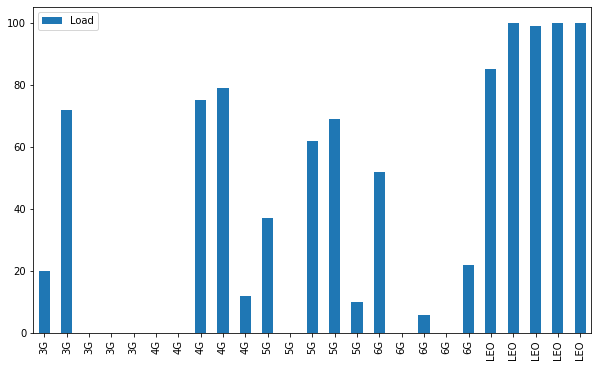

In [121]:
df = pd.read_csv(file_path+"/decision_matrix.csv",header = None)
# number of AP/BSs per RAT
M  = 5
# number of simultaneous connections per UE
C = 10
# number of users
U = 100

selected_RATs = RAT_filter(RAT_scores,0.0,RATs).columns
no_of_RATs = selected_RATs.size


# Create a matrix of AP/BS criteria values for each RAT

APs = np.zeros((no_of_RATs, M, dm_ap.shape[1]))
all_APs = np.zeros((no_of_RATs*M, dm_ap.shape[1]))
RAT_AP = []
cell_nos = np.ones(no_of_RATs*M, dtype=np.int64)
cellIDs = []
RATs_group = []
# initial criteria values for the APs decision matrix 
      
for i in range(no_of_RATs):
    rat = selected_RATs[i]
    selected_row = df[df.iloc[:, 0] == rat].iloc[0][7:].values.astype(np.float64)
    RAT_AP += [rat] * M
    for j in range(M):
        selected_row[2] = random_SINR() # 
        APs[i, j] = selected_row
        all_APs[j+i*M] = selected_row
        cell_nos[j+i*M] = j+1
        RATs_group.append(rat)
        cellIDs.append(f'AP{j+1}')


users_per_RAT = {rat: 0 for rat in selected_RATs}



for i in range(U):
    normal_ap = minmax_normalize(all_APs, criteria_types[6:])
    weights = critic_weighting(all_APs)
    AP_scores = calculate_saw_scores(normal_ap,weights)

    df = pd.DataFrame(list(zip(cell_nos,AP_scores)),index=RAT_AP)
    AP_rankings = df.sort_values(by=1, ascending=False)

    # updating the load criteria on the AP matrix after selection
    for j in range(C): # top C AP are selected
        rat = AP_rankings.iloc[j].name
        rat_index = np.where(selected_RATs == rat)[0][0]
        ap_index = AP_rankings.iloc[j].values[0].astype(np.int64) - 1

        #update the load criteria
        all_APs[ap_index + rat_index*M][0] += 1 
        users_per_RAT[rat] += 1




# normal_ap = minmax_normalize(all_APs, criteria_types[6:])
# weights = critic_weighting(all_APs)
# AP_scores = calculate_saw_scores(normal_ap,weights)

# Create a dictionary to store the number of users per RAT

# APs_per_RAT = {rat: 10 for rat in selected_RATs}
# APs_per_RAT

# print(AP_rankings)


df_updated = pd.DataFrame(cellIDs, columns = ['AP'],index= RATs_group)
df_updated['Load'] = all_APs[:,0].astype(np.int64)


df_loadperRAT = pd.DataFrame(users_per_RAT, index=['Load']).T
df_loadperRAT
df_updated.plot(kind='bar', figsize=(10, 6))


